In [1]:
from QHD import *

import matplotlib.pyplot as plt
import numpy as np

# The Gaussian Potential

We first must define the potential along with its parameters, as described below, given by Rossman et. al

### 1. The Potential

**Parameters**

$v_0 = 1$ Hartree

$\sigma = 0.1$ Angstrom

**Potential**

$V(q)=-v_0*e^{(\frac{-q^2}{2*\sigma^2})}$

We can define this potential as `potential`, and define the given parameters as `D`, `alpha`, and `q_0` as described below. We will also need to define the dependent variable, in this case `q` as a range using the `linspace` function found in `numpy`. The parameters are all in *atomic units*.

In [2]:
v_0 = 5 # Hartree
sigma = 1.1 # Angstrom
sigma1 = 1.5
sigma2 = 1.01
q = np.linspace(-5, 5, 1000)

alpha = 1/(2*sigma1**2)

potential = -v_0*np.exp(-q**2/(2*sigma**2))
potential1 = -v_0*np.exp(-alpha*q**2)
#potential1 = -v_0*np.exp(-q**2/(2*sigma1**2))
potential2 = -v_0*np.exp(-q**2/(2*sigma2**2))

Now that the parameters and potential have been defined, the potential can be plotted using the `matplotlib.pyplot` library. Any of the lines can be changed as desired.

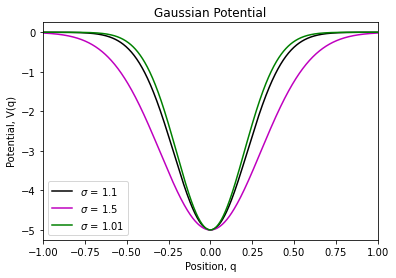

In [3]:
q = np.linspace(-1, 1, 1000)
plt.plot(q, potential, 'k')
plt.plot(q, potential1, "m")
plt.plot(q, potential2, "g")
plt.title("Gaussian Potential")
plt.legend([r"$\sigma$ = 1.1", r"$\sigma$ = 1.5", r"$\sigma$ = 1.01"])
plt.xlim(-1, 1)
plt.xlabel("Position, q")
plt.ylabel("Potential, V(q)")
#plt.savefig("gaussian_vVq.png")
plt.show()

New potential equation given by: https://demonstrations.wolfram.com/EnergiesForParticleInAGaussianPotentialWell/

### 2. Derivation of  QHD formulas

Here, we use the pysces library, able to derive the equations of motion in the QHD method. We will need to define the `q`, `p`, `p2`, `x`, `x2`, and `xp` variables. In order to do this, we must first calculate the first and second derivatives of the potential of interest, defined in section 1. We will also use a change of variables as well, described below.

**2.1 The First and Second Derivatives of the Potential**

To take the derivatives, we must represent the potential symbolically. This can be done by:

In [4]:
# First, we must define all the parameters as stated in section 1 as symbols:

v_0, sigma, q, alpha = symbols("v_0, sigma q alpha")

# When computing symbolically, we do not need to use the numpy exponential function.

potential_sym = -v_0*exp(-alpha*q**2)

Now that the potential is represented symbolically, we may take the first and second derivatives, described by diff1 and diff2, respectively

In [5]:
diff1 = diff(potential_sym, q)
diff2 = diff(diff1, q)

diff1, diff2

**2.2 Change of Variable**

We can do a change of variable in the potential to:

$$x=e^{(\frac{-q^2}{2*\sigma^2})}$$

And so:

$$V(q)=A*x$$

We will now take the first and second derivatives of the original potential, and then perform the change of variables.

- The First Derivative:

In [6]:
x = Symbol("x")

diff11 = diff1.replace(exp(-q**2/(2*sigma**2)), x)

diff11

- The Second Derivative:

In [7]:
diff22 = diff2.replace(exp(-q**2/(2*sigma**2)), x)

diff22

**2.3 Solving for the Equations of Motion**

We must solve the equations of motion for `q`, `p`, `x`, `x2`, and `xp` using the parameters defined in section 1.

In [8]:
# Again, we must first define all variables as symbols. #

q, p, p2, x, x2, xp, dt, mass, D, alpha, sigma, q2 = symbols("q, p, p2, x, x2, xp, dt, mass, D, alpha, sigma q2")
q_0 = 0.0

########## EOM Calculations ##########

# If you want to see the output of any of the below, uncomment the desired print line. #

# There are two ways to derive the EOM's, using the `time_deriv` function and then the original way is with `QHD_int`
# The `time_deriv` function is used as it's more versatile at this time, however it's still not perfect.
# `QHD_int` uses the `time_deriv` function

px = xp
q1 = str(time_deriv(q, 1)*dt + q)
print("q = " + str(q1))

q21 = str(time_deriv(q, 2)*dt + q2)
print(q21)

x = exp(-alpha*q**2)
x1 = sympify(str(time_deriv(x, 1)).replace("exp(-alpha*q**2)", "x"))
x1 = str((symmetrize(x1))*(0.5)*dt + Symbol("x"))
x1 = str(x1).replace("p*q*x", "q*xp")
print("x = " + str(x1))

p1 = str(time_deriv(p, 1)).replace("v(q)", str(potential_sym))
p1 = expand(sympify(p1).doit())
p1 = str(p1).replace("exp(-2.0*q**2)", "x2").replace("alpha**2", "0")
p1 = sympify(p1)
p1 = str(symmetrize(p1)*(0.5)*dt + p).replace("exp(-alpha*q**2)", "x")
print("p = " + str(p1))

x = Symbol("x")
p21 = str(time_deriv(p, 2)).replace("v(q)", str(potential_sym))
p21 = expand(sympify(p21).doit())
p21 = str(-p21).replace("exp(-alpha*q**2)", "x").replace("exp(-2*alpha*q**2)", "x2").replace("alpha**2", "0")
p21 = str(symmetrize(p21)*(0.5)*dt + p2).replace("exp(-alpha*q**2)", "x").replace("exp(-2.0*q**2)", "x2")
p21 = str(p21).replace("p*q*v_0*x", "v_0*q*xp")
print("p2 = " + str(p21))

q = dt*p/mass + q
2*dt*p*q/mass + q2
x = -1.0*alpha*dt*q*xp/mass + x
p = -1.0*alpha*dt*q*v_0*x + p
p2 = -2.0*alpha*dt*v_0*q*xp + p2


In [9]:
alpha = Symbol("alpha")

def integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,dt,mass,alp,D):
    x2 = x2 - (q*x*(xp - x*p))/mass*0.5*dt #4.0*(alp/mass)*x*(xp - x*p)*0.5*dt
    x2 = exp(-2.0*alp*(dt*p/mass)**2)*x2
    x2 = x2 - (q*x*(xp - x*p))/mass*0.5*dt  #4.0*(alp/mass)*x*(xp - x*p)*0.5*dt
    return x2

def integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,dt,mass,alp,D):
    xp = xp + 0.5*dt*(((x*(p2-2*p*p)))/(-2*mass) - (-v_0*x2*2*alpha*q+v_0**2*4*alpha**2*q2*x2))#0.5*dt*(2.0*alp*D*(x*(3.0*x2 - 2*x*x) - x2)  - (alp*x/mass)*(p2 - 2.0*p*p) )
    xp = exp(-2*alpha*(dt*p/mass)**2)*xp
    xp = xp + 0.5*dt*(((x*(p2-2*p*p)))/(-2*mass) - (-v_0*x2*2*alpha*q+v_0**2*4*alpha**2*q2*x2))#0.5*dt*(2.0*alp*D*(x*(3.0*x2 - 2*x*x) - x2)  - (alp*x/mass)*(p2 - 2.0*p*p) )
    return xp

Now, we are ready to make plots of the data based on the EOM's as computed above.

# 3. Graphing

**3.1 Generating Time-Dependent Values**

We will first define all of the parameters necessary to perform the QHD calculations.

In [10]:
### Specific Parameters: ###

v_0 = 5 # Hartree
sigma = 0.75 # Angstrom
mass = 1836 # a.u.


### Constants: ###

hbar = 0.6582  # eV * fs
convert = (1.0/17.586)
mass, q0, p0, s0, ps0, T, dt = 2980.0*convert, 0.15, 0.0, 0.05, 0.0, 500, 0.1
#alpha = 2.567
alpha = 1/(2*sigma**2)
alp = alpha


##### Initial Conditions #####

t = 0.0    
Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,pq,q2,p2,x,x2,xp,xq = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
q_0 = 0.0
q2 = q*q + s0*s0
pq = ps0*s0 + q*p
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2
x = exp(-alp*q0)*exp(0.5*alp*alp*s0*s0)
x2 = exp(-2.0*alp*q0)*exp(2.0*alp*alp*s0*s0)
xq = x*(q-alp*s0*s0)
xp = x*(p - s0*ps0*alp)

##### ----- #####

xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

x = eval(x1)

p2 = eval(p21)

q2 = eval(q21)

p = eval(p1)

q = eval(q1)

p = eval(p1)

q2 = eval(q21)

p2 = eval(p21)

x = eval(x1)

x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)


Ekin_cl = 0.5*p*p/mass
Ekin    = 0.5*p2/mass
Epot_cl = -v_0*math.exp(-alpha*q**2)
Epot = -v_0*x
Etot_cl = Ekin_cl + Epot_cl
Etot    = Ekin    + Epot

##### Empty Lists for Data Storage: #####

q_list = [] 
p_list = []
e_list = []
e1_list = []

Now that the parameters have been defined, we can compute the desired values of position and energy over a given time interval.

In [11]:
### Time how long it takes to compute ###

import time 
begin = time.time()


### Compute the x values ###

dt = 0.1 # step size
t_i = 0.0 # start
t_f = 1000 # finish


### Compute the y values ###

i=0
while i<1:        
    s = (q2 - q*q)
    if s>0.0:
        s = math.sqrt(s)
    else: 
        s = 0.0
    if s>0.0:
        ps = (pq - p*q)/s
    else: 
        ps = 0.0
    i = i+1


while t_i<=t_f:
    xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

    x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

    x = eval(x1)

    p2 = eval(p21)
    
    q2 = eval(q21)

    p = eval(p1)

    q = eval(q1)

    p = eval(p1)
    
    q2 = eval(q21)

    p2 = eval(p21)

    x = eval(x1)

    x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

    xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)
    
    Ekin_cl = 0.5*p*p/mass
    Ekin    = 0.5*p2/mass
    Epot_cl = -v_0*math.exp(-alpha*q**2)
    Epot = -v_0*x
    Etot_cl = Ekin_cl + Epot_cl
    Etot    = Ekin    + Epot


    t_i = t_i + dt
    i=0
    while i<1:
        s = (q2 - q*q)
        if s>0.0:
            s = math.sqrt(s)
        else: 
            s = 0.0
        if s>0.0:
            ps = (pq - p*q)/s
        else: 
            ps = 0.0

        i = i+1
        q_list.append(q)
        p_list.append(p)
        e_list.append(Etot)
        e1_list.append(Etot_cl)
        
        print(q)


### Compute the end time ###
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

0.149862153734996
0.149689903888569
0.149448862326088
0.149139137234363
0.148760867659524
0.148314223468270
0.147799405300137
0.147216644510559
0.146566203104452
0.145848373660055
0.145063479242687
0.144211873308085
0.143293939594947
0.142310092006293
0.141260774479236
0.140146460842736
0.138967654662923
0.137724889075544
0.136418726605103
0.135049758970280
0.133618606875193
0.132125919786108
0.130572375693214
0.128958680857090
0.127285569539531
0.125553803718424
0.123764172786409
0.121917493233071
0.120014608310498
0.118056387682024
0.116043727054085
0.113977547791111
0.111858796513472
0.109688444678520
0.107467488144840
0.105196946719871
0.102877863691116
0.100511305341226
0.0980983604472671
0.0956401397645903
0.0931377754957119
0.0905924207447196
0.0880052489577354
0.0853774533500308
0.0827102463204259
0.0800048588536508
0.0772625399113826
0.0744845558127067
0.0716721896047796
0.0688267404244983
0.0659495228519997
0.0630418662568296
0.0601051141376350
0.0571406234562345
0.0541497639

-0.148915499145561
-0.148595727754941
-0.148207912186163
-0.147752349226778
-0.147229368675278
-0.146639332888730
-0.145982636303903
-0.145259704933256
-0.144470995837240
-0.143616996574411
-0.142698224630929
-0.141715226831065
-0.140668578730356
-0.139558883993120
-0.138386773756028
-0.137152905979479
-0.135857964788493
-0.134502659804870
-0.133087725472337
-0.131613920376371
-0.130082026560391
-0.128492848839936
-0.126847214116457
-0.125145970692228
-0.123389987587902
-0.121580153864117
-0.119717377948517
-0.117802586969467
-0.115836726097673
-0.113820757896819
-0.111755661684270
-0.109642432902764
-0.107482082503974
-0.105275636344673
-0.103024134596180
-0.100728631167645
-0.0983901931436563
-0.0960099002365233
-0.0935888442535300
-0.0911281285793338
-0.0886288676736020
-0.0860921865838872
-0.0835192204736516
-0.0809111141652697
-0.0782690216977538
-0.0755941058988714
-0.0728875379712492
-0.0701504970919893
-0.0673841700252571
-0.0645897507472450
-0.0617684400828561
-0.0589214453534

0.151771202137924
0.151718133017640
0.151600534023009
0.151418352122364
0.151171561646278
0.150860164477161
0.150484190230684
0.150043696428584
0.149538768662367
0.148969520747391
0.148336094866805
0.147638661704767
0.146877420568346
0.146052599497514
0.145164455362577
0.144213273948425
0.143199370024916
0.142123087402757
0.140984798974194
0.139784906737851
0.138523841807052
0.137202064400962
0.135820063817915
0.134378358390284
0.132877495420302
0.131318051096237
0.129700630388381
0.128025866924318
0.126294422843015
0.124506988627261
0.122664282914094
0.120767052282850
0.118816071020543
0.116812140864348
0.114756090720992
0.112648776362950
0.110491080101371
0.108283910435755
0.106028201680447
0.103724913568080
0.101375030830188
0.0989795627552403
0.0965395427244545
0.0940560277257754
0.0915300978464991
0.0889628557450660
0.0863554261026181
0.0837089550549665
0.0810246096056762
0.0783035770210231
0.0755470642076288
0.0727562970736231
0.0699325198742222
0.0670769945426505
0.0641910000073

-0.144250492783889
-0.145169751147819
-0.146026160274964
-0.146819381214103
-0.147549105461486
-0.148215055144312
-0.148816983178213
-0.149354673398047
-0.149827940661456
-0.150236630924659
-0.150580621290092
-0.150859820025552
-0.151074166554618
-0.151223631418208
-0.151308216207218
-0.151327953466312
-0.151282906568988
-0.151173169564185
-0.150998866994753
-0.150760153688239
-0.150457214520504
-0.150090264152799
-0.149659546743002
-0.149165335631807
-0.148607933004743
-0.147987669530963
-0.147304903979818
-0.146560022816316
-0.145753439776586
-0.144885595424561
-0.143956956691123
-0.142968016396988
-0.141919292760657
-0.140811328892780
-0.139644692278303
-0.138419974247776
-0.137137789439222
-0.135798775251937
-0.134403591293627
-0.132952918822234
-0.131447460183807
-0.129887938247738
-0.128275095840658
-0.126609695180243
-0.124892517310132
-0.123124361537134
-0.121306044871814
-0.119438401473515
-0.117522282100807
-0.115558553568275
-0.113548098210510
-0.111491813354085
-0.109390610

0.0857270252021375
0.0882658050532150
0.0907686067613746
0.0932344138649829
0.0956622258265357
0.0980510584951637
0.100399944558968
0.102707933986616
0.104974094457661
0.107197511781089
0.109377290301632
0.111512553293437
0.113602443340708
0.115646122704991
0.117642773678831
0.119591598925531
0.121491821804848
0.123342686684454
0.125143459237064
0.126893426723176
0.128591898259383
0.130238205072312
0.131831700738223
0.133371761408391
0.134857786020405
0.136289196495549
0.137665437922486
0.138985978727474
0.140250310831366
0.141457949793703
0.142608434944188
0.143701329501876
0.144736220682421
0.145712719793732
0.146630462320396
0.147489107997243
0.148288340872413
0.149027869360307
0.149707426284776
0.150326768912909
0.150885678979782
0.151383962704486
0.151821450797779
0.152197998461656
0.152513485381124
0.152767815708464
0.152960918040208
0.153092745387068
0.153163275136995
0.153172509011566
0.153120473015802
0.153007217381575
0.152832816504662
0.152597368875512
0.152300997003768
0.15

-0.0218668253490928
-0.0248526290681180
-0.0278289624852677
-0.0307946856888929
-0.0337486607968194
-0.0366897521607713
-0.0396168265706449
-0.0425287534594435
-0.0454244051097003
-0.0483026568622306
-0.0511623873280656
-0.0540024786044240
-0.0568218164955804
-0.0596192907394859
-0.0623937952409877
-0.0651442283124824
-0.0678694929228223
-0.0705684969552694
-0.0732401534752672
-0.0758833810087692
-0.0784971038318262
-0.0810802522720950
-0.0836317630228870
-0.0861505794703236
-0.0886356520341152
-0.0910859385224204
-0.0935004045011834
-0.0958780236782788
-0.0982177783027302
-0.100518659579192
-0.102779668097811
-0.104999814279515
-0.107178118836677
-0.109313613249050
-0.111405340254757
-0.113452354356054
-0.115453722339502
-0.117408523810077
-0.119315851738693
-0.121174813022495
-0.122984529057230
-0.124744136320888
-0.126452786967761
-0.128109649431944
-0.129713909039280
-0.131264768626637
-0.132761449167347
-0.134203190401603
-0.135589251470487
-0.136918911552327
-0.138191470499959
-0

-0.0435860034757404
-0.0404729022876487
-0.0373407257315914
-0.0341909475243672
-0.0310250502409421
-0.0278445245865376
-0.0246508686625240
-0.0214455872259990
-0.0182301909429631
-0.0150061956350400
-0.0117751215197293
-0.00853849244422317
-0.00529783511286581
-0.00205467830838615
0.00118944789291451
0.00443301291178119
0.00767448646213518
0.0109123393523617
0.0141450442913430
0.0173710766987645
0.0205889155191639
0.0237970440391343
0.0269939507070342
0.0301781299545059
0.0333480830190458
0.0365023187668242
0.0396393545149032
0.0427577168519582
0.0458559424565685
0.0489325789121084
0.0519861855172382
0.0550153340909696
0.0580186097712592
0.0609946118060680
0.0639419543358155
0.0668592671661534
0.0697451965299825
0.0725984058376487
0.0754175764142605
0.0782014082230947
0.0809486205740773
0.0836579528163574
0.0863281650140258
0.0889580386040713
0.0915463770357084
0.0940920063902628
0.0965937759808511
0.0990505589311483
0.101461252732595
0.103824779779465
0.106140087881263
0.108406150752

0.0480999700846774
0.0450876544497807
0.0420555416271885
0.0390049696529109
0.0359372833873994
0.0328538339714504
0.0297559782870635
0.0266450784236570
0.0235225011499895
0.0203896173920889
0.0172478017174334
0.0140984318255754
0.0109428880453391
0.00778255283866800
0.00461881031113321
0.00145304572906003
-0.00171335495683512
-0.00487900558146172
-0.00804252022925064
-0.0112025136922097
-0.0143576019224770
-0.0175064024797640
-0.0206475349741311
-0.0237796215045889
-0.0269012870940610
-0.0300111601212902
-0.0331078727503045
-0.0361900613580958
-0.0392563669611925
-0.0423054356418316
-0.0453359189744587
-0.0483464744532925
-0.0513357659217075
-0.0543024640041847
-0.0572452465415821
-0.0601627990304671
-0.0630538150672391
-0.0659169967977498
-0.0687510553731023
-0.0715547114122809
-0.0743266954722199
-0.0770657485258822
-0.0797706224488638
-0.0824400805149892
-0.0850728979013003
-0.0876678622027765
-0.0902237739570559
-0.0927394471793504
-0.0952137099076713
-0.0976454047583994
-0.1000333

-0.0663939679840651
-0.0635351844671443
-0.0606483383576556
-0.0577347266413717
-0.0547956549540844
-0.0518324371299485
-0.0488463947553970
-0.0458388567279238
-0.0428111588190122
-0.0397646432404699
-0.0367006582134254
-0.0336205575392322
-0.0305257001715357
-0.0274174497887612
-0.0242971743662973
-0.0211662457476681
-0.0180260392140093
-0.0148779330511960
-0.0117233081139994
-0.00856354738668914
-0.00540003553954044
-0.00223415848074750
0.000932697096704302
0.00409914417360540
0.00726379586887194
0.0104252659099669
0.0135821691096232
0.0167331218490409
0.0198767425676721
0.0230116522596449
0.0261364749768211
0.0292498383384206
0.0323503740470861
0.0354367184112072
0.0385075128732634
0.0415614045438944
0.0445970467413509
0.0476130995359340
0.0506082302989806
0.0535811142559122
0.0565304350428235
0.0594548852660491
0.0623531670641195
0.0652239926714833
0.0680660849833518
0.0708781781210032
0.0736590179968656
0.0764073628786885
0.0791219839521062
0.0818016658808941
0.0844452073642213
0.

0.0943868984891038
0.0918464897964196
0.0892632397097304
0.0866383195234647
0.0839729232102399
0.0812682668036647
0.0785255877616782
0.0757461443112313
0.0729312147751676
0.0700820968822033
0.0672001070609462
0.0642865797189296
0.0613428665076656
0.0583703355747478
0.0553703708040502
0.0523443710450868
0.0492937493325980
0.0462199320974385
0.0431243583698327
0.0400084789760565
0.0368737557295909
0.0337216606177694
0.0305536749849204
0.0273712887129711
0.0241759994004502
0.0209693115407815
0.0177527357007242
0.0145277876997635
0.0112959877912100
0.00805885984571049
0.00481793053782122
0.00157472853623587
-0.00166921630179589
-0.00491237373138242
-0.00815321391581884
-0.0113902082169712
-0.0146218299799149
-0.0178465553115834
-0.0210628638532376
-0.0242692395466209
-0.0274641713937141
-0.0306461542100525
-0.0338136893716111
-0.0369652855553054
-0.0400994594731895
-0.0432147366004663
-0.0463096518974507
-0.0493827505256491
-0.0524325885581334
-0.0554577336844021
-0.0584567659099233
-0.061

-0.129757290345950
-0.128154140325652
-0.126498305687467
-0.124790600230683
-0.123031854754629
-0.121222916448540
-0.119364648289671
-0.117457928450639
-0.115503649716968
-0.113502718915703
-0.111456056355868
-0.109364595281495
-0.107229281337841
-0.105051072051335
-0.102830936323716
-0.100569853940733
-0.0982688150956954
-0.0959288199280779
-0.0935508780773111
-0.0911360082517897
-0.0886852378130694
-0.0861996023751368
-0.0836801454185660
-0.0811279179193048
-0.0785439779917625
-0.0759293905458117
-0.0732852269572491
-0.0706125647512102
-0.0679124872979725
-0.0651860835205397
-0.0624344476133498
-0.0596586787714114
-0.0568598809291389
-0.0540391625081222
-0.0511976361730450
-0.0483364185949385
-0.0454566302209468
-0.0425593950497612
-0.0396458404118785
-0.0367170967538316
-0.0337742974255428
-0.0308185784699574
-0.0278510784141227
-0.0248729380608933
-0.0218853002804600
-0.0188893098009233
-0.0158861129971561
-0.0128768576772301
-0.00986269286571137
-0.00684476858316740
-0.00382423562

0.151576394774749
0.151982089522144
0.152327063274866
0.152611151285667
0.152834212753468
0.152996130908579
0.153096813091553
0.153136190825697
0.153114219883235
0.153030880345079
0.152886176654151
0.152680137662169
0.152412816669766
0.152084291459813
0.151694664323763
0.151244062080826
0.150732636089745
0.150160562252937
0.149528041012728
0.148835297339391
0.148082580710690
0.147270165082599
0.146398348850878
0.145467454803136
0.144477830061053
0.143429846012378
0.142323898232360
0.141160406394239
0.139939814168433
0.138662589110085
0.137329222534611
0.135940229380925
0.134496148062023
0.132997540302632
0.131444990963651
0.129839107853125
0.128180521523534
0.126469885055215
0.124707873825727
0.122895185265069
0.121032538596631
0.119120674563845
0.117160355142523
0.115152363238908
0.113097502373517
0.110996596350889
0.108850488915416
0.106660043393439
0.104426142321883
0.102149687063722
0.0998315974106028
0.0974728111730292
0.0950742837585174
0.0926369877381947
0.0901619124023441
0.087

-0.103888302966271
-0.106099287943745
-0.108267674066358
-0.110392514537449
-0.112472875817617
-0.114507838118501
-0.116496495906540
-0.118437958416204
-0.120331350172111
-0.122175811519368
-0.123970499161391
-0.125714586704414
-0.127407265207790
-0.129047743739155
-0.130635249933449
-0.132169030554718
-0.133648352059598
-0.135072501161284
-0.136440785392793
-0.137752533668253
-0.139007096840921
-0.140203848256623
-0.141342184301261
-0.142421524941034
-0.143441314253992
-0.144401020951567
-0.145300138888680
-0.146138187561096
-0.146914712588653
-0.147629286183063
-0.148281507598981
-0.148871003567094
-0.149397428708021
-0.149860465925855
-0.150259826780249
-0.150595251835997
-0.150866510989134
-0.151073403768661
-0.151215759613041
-0.151293438120752
-0.151306329274203
-0.151254353636465
-0.151137462520310
-0.150955638129185
-0.150708893669810
-0.150397273436207
-0.150020852865045
-0.149579738562301
-0.149074068301309
-0.148504010992379
-0.147869766624259
-0.147171566177781
-0.146409671

0.0547225225129128
0.0576988495236985
0.0606488891166385
0.0635713101435540
0.0664647962080918
0.0693280463865019
0.0721597759378637
0.0749587170027505
0.0777236192893337
0.0804532507459500
0.0831463982191788
0.0858018680965071
0.0884184869326952
0.0909951020589938
0.0935305821744068
0.0960238179182428
0.0984737224232468
0.100879231848660
0.103239305892610
0.105552928283298
0.107819107248500
0.110036875962984
0.112205292973479
0.114323442600926
0.116390435319795
0.118405408114307
0.120367524811492
0.122275976391049
0.124129981272058
0.125928785576657
0.127671663370834
0.129357916882568
0.130986876697596
0.132557901933135
0.134070380389937
0.135523728683108
0.136917392352145
0.138250845950720
0.139523593116715
0.140735166623115
0.141885128410324
0.142973069600536
0.143998610494790
0.144961400553355
0.145861118360106
0.146697471571538
0.147470196851096
0.148179059789464
0.148823854811467
0.149404405070234
0.149920562329231
0.150372206832785
0.150759247165685
0.151081620102414
0.151339290

-0.0417163589833781
-0.0446922575963969
-0.0476496411626445
-0.0505872669658366
-0.0535038969998311
-0.0563982982788848
-0.0592692431539089
-0.0621155096355827
-0.0649358817251698
-0.0677291497538582
-0.0704941107314185
-0.0732295687049403
-0.0759343351283690
-0.0786072292435197
-0.0812470784731987
-0.0838527188270048
-0.0864229953203263
-0.0889567624069842
-0.0914528844259045
-0.0939102360621280
-0.0963277028223916
-0.0987041815254326
-0.101038580807086
-0.103329821640156
-0.105576837868956
-0.107778576758316
-0.109933999556773
-0.112042082073557
-0.114101815268884
-0.116112205857002
-0.118072276921303
-0.119981068540750
-0.121837638426761
-0.123641062569604
-0.125390435893280
-0.127084872917773
-0.128723508427466
-0.130305498144460
-0.131830019405445
-0.133296271840716
-0.134703478053857
-0.136050884300576
-0.137337761165099
-0.138563404232538
-0.139727134755547
-0.140828300313623
-0.141866275463345
-0.142840462377850
-0.143750291473844
-0.144595222024458
-0.145374742756260
-0.146088

0.0206684316977023
0.0238535637155400
0.0270276983360561
0.0301893713055744
0.0333371238568527
0.0364695033800576
0.0395850640967770
0.0426823677365220
0.0457599842151206
0.0488164923143662
0.0518504803622383
0.0548605469129803
0.0578453014262855
0.0608033649448156
0.0637333707692523
0.0666339651300649
0.0695038078551649
0.0723415730326066
0.0751459496674957
0.0779156423322631
0.0806493718094741
0.0833458757263498
0.0860039091801995
0.0886222453539791
0.0911996761212205
0.0937350126396038
0.0962270859324815
0.0986747474576986
0.101076869663095
0.103432346528122
0.105740094091047
0.107999050961281
0.110208178816393
0.112366462883461
0.114472912404424
0.116526561085185
0.118526467528265
0.120471715648838
0.122361415074061
0.124194701525664
0.125970737185782
0.127688711046106
0.129347839240458
0.130947365360925
0.132486560757765
0.133964724823298
0.135381185260067
0.136735298333566
0.138026449109855
0.139254051678432
0.140417549360737
0.141516414904661
0.142550150665494
0.143518288773705


-0.0127145354479779
-0.0159488095971306
-0.0191755308523245
-0.0223931713368625
-0.0256002075633584
-0.0287951211561882
-0.0319763995684356
-0.0351425367934705
-0.0382920340713314
-0.0414234005901168
-0.0445351541826186
-0.0476258220184495
-0.0506939412919374
-0.0537380599060648
-0.0567567371527433
-0.0597485443897078
-0.0627120657143100
-0.0656458986344801
-0.0685486547371063
-0.0714189603540558
-0.0742554572260375
-0.0770568031644640
-0.0798216727114369
-0.0825487577979303
-0.0852367684001992
-0.0878844331943857
-0.0904905002092361
-0.0930537374767832
-0.0955729336807810
-0.0980468988026140
-0.100474464764332
-0.102854486068395
-0.105185840433634
-0.107467429426874
-0.109698179089575
-0.111877040558807
-0.114002990681763
-0.116075032622994
-0.118092196463456
-0.120053539790401
-0.121958148277100
-0.123805136251336
-0.125593647251527
-0.127322854569348
-0.128991961777637
-0.130600203242386
-0.132146844617548
-0.133631183321432
-0.135052548993401
-0.136410303929621
-0.137703843496617
-

-0.0237882542695598
-0.0207733766822086
-0.0177503846290485
-0.0147204617786152
-0.0116847931521809
-0.00864456490278325
-0.00560096409057595
-0.00255517845383928
0.000491603824969680
0.00353819435870261
0.00658340480107068
0.00962604709874183
0.0126649337504161
0.0156988780732602
0.0187266944770294
0.0217471987461553
0.0247592083300205
0.0277615426415942
0.0307530233645441
0.0337324747688937
0.0366987240352371
0.0396506015874773
0.0425869414340034
0.0455065815171734
0.0484083640709256
0.0512911359862966
0.0541537491845823
0.0569950609978403
0.0598139345563928
0.0626092391829599
0.0653798507930162
0.0681246523009413
0.0708425340315061
0.0735323941362172
0.0761931390140217
0.0788236837358612
0.0814229524725510
0.0839898789254516
0.0865234067593960
0.0890224900373322
0.0914860936561437
0.0939131937831126
0.0963027782925005
0.0986538472017282
0.100965413106653
0.103236501615454
0.105466151780651
0.107653416528818
0.109797363087544
0.111897073409256
0.113951644591508
0.115960189293388
0.11

0.0772347985979716
0.0745077158500184
0.0717485189901144
0.0689583849230288
0.0661385056261226
0.0632900875421704
0.0604143509637968
0.0575125294104078
0.0545858689985001
0.0516356278062330
0.0486630752331438
0.0456694913558785
0.0426561662807975
0.0396243994942978
0.0365754992116712
0.0335107817252935
0.0304315707529087
0.0273391967867385
0.0242349964441107
0.0211203118202604
0.0179964898439124
0.0148648816362103
0.0117268418735060
0.00858372815447671
0.00543690037198108
0.00228772009001584
-0.000862450073921495
-0.00401224706081165
-0.00716030797623742
-0.0103052706905090
-0.0134457744327013
-0.0165804603785659
-0.0197079722323314
-0.0228269568024541
-0.0259360645714294
-0.0290339502598164
-0.0321192733846703
-0.0351906988126163
-0.0382468973078308
-0.0412865460752289
-0.0443083292991820
-0.0473109386781121
-0.0502930739553280
-0.0532534434464822
-0.0561907645640326
-0.0591037643391028
-0.0619911799411267
-0.0648517591956636
-0.0676842611007527
-0.0704874563421654
-0.0732601278078891

-0.133234112421428
-0.131722103337985
-0.130154658191686
-0.128532481158044
-0.126856299045608
-0.125126860801761
-0.123344937014022
-0.121511319407915
-0.119626820342397
-0.117692272303847
-0.115708527399498
-0.113676456851201
-0.111596950490313
-0.109470916254460
-0.107299279686853
-0.105082983438775
-0.102822986775797
-0.100520265088187
-0.0981758094059436
-0.0957906259187872
-0.0933657355013875
-0.0909021732440315
-0.0884009879888728
-0.0858632418718335
-0.0832900098701658
-0.0806823793556216
-0.0780414496531122
-0.0753683316046898
-0.0726641471386225
-0.0699300288432891
-0.0671671195455676
-0.0643765718933538
-0.0615595479418018
-0.0587172187428472
-0.0558507639375416
-0.0529613713507014
-0.0500502365873521
-0.0471185626304331
-0.0441675594392165
-0.0411984435478838
-0.0382124376637049
-0.0352107702642641
-0.0321946751931838
-0.0291653912538102
-0.0261241618003370
-0.0230722343258673
-0.0200108600469341
-0.0169412934840280
-0.0138647920377135
-0.0107826155599484
-0.007696025920258

0.150830169053739
0.151260695769001
0.151628569530560
0.151933718167401
0.152176095676661
0.152355682101703
0.152472483402140
0.152526531316172
0.152517883215538
0.152446621953383
0.152312855705297
0.152116717803748
0.151858366566127
0.151537985116547
0.151155781201575
0.150711986999969
0.150206858926544
0.149640677430204
0.149013746786179
0.148326394882496
0.147578973000653
0.146771855590493
0.145905440039217
0.144980146434491
0.143996417321571
0.142954717454371
0.141855533540389
0.140699373979399
0.139486768595819
0.138218268364670
0.136894445131030
0.135515891322913
0.134083219657500
0.132597062840658
0.131058073259706
0.129466922669408
0.127824301871157
0.126130920385392
0.124387506117253
0.122594805015549
0.120753580725102
0.118864614232597
0.116928703506051
0.114946663128079
0.112919323923143
0.110847532579012
0.108732151262675
0.106574057231001
0.104374142436436
0.102133313128104
0.0998524894486390
0.0975326050271815
0.0951746065689171
0.0927794534416244
0.0903481172596787
0.087

-0.124645117233255
-0.126355772093910
-0.128013096960943
-0.129616249502330
-0.131164406014330
-0.132656762086921
-0.134092533274080
-0.135470955767534
-0.136791287072534
-0.138052806684163
-0.139254816762637
-0.140396642806022
-0.141477634318768
-0.142497165474412
-0.143454635770817
-0.144349470676281
-0.145181122264856
-0.145949069839221
-0.146652820539480
-0.147291909936254
-0.147865902606488
-0.148374392690429
-0.148817004428252
-0.149193392674911
-0.149503243391796
-0.149746274113902
-0.149922234391226
-0.150030906203264
-0.150072104345476
-0.150045676786769
-0.149951504997066
-0.149789504244173
-0.149559623859249
-0.149261847470279
-0.148896193203056
-0.148462713849317
-0.147961497001732
-0.147392665155613
-0.146756375777269
-0.146052821339074
-0.145282229321401
-0.144444862181686
-0.143541017290970
-0.142571026838389
-0.141535257704140
-0.140434111301559
-0.139268023389014
-0.138037463852399
-0.136742936459063
-0.135384978584099
-0.133964160909933
-0.132481087100241
-0.130936393

0.117539386054184
0.119524147282122
0.121453111272282
0.123325418890718
0.125140239494139
0.126896771240229
0.128594241376847
0.130231906510335
0.131809052853244
0.133324996451790
0.134779083393456
0.136170689995145
0.137499222972346
0.138764119589809
0.139964847794236
0.141100906329547
0.142171824835256
0.143177163928539
0.144116515270586
0.144989501617786
0.145795776858372
0.146535026035065
0.147206965354309
0.147811342182649
0.148347935030781
0.148816553525808
0.149217038372180
0.149549261301797
0.149813125013707
0.150008563103802
0.150135539984892
0.150194050797475
0.150184121311517
0.150105807819484
0.149959197020860
0.149744405898311
0.149461581585654
0.149110901227713
0.148692571832135
0.148206830113180
0.147653942327484
0.147034204101734
0.146347940252189
0.145595504595936
0.144777279753732
0.143893676944298
0.142945135769854
0.141932123992723
0.140855137302772
0.139714699075475
0.138511360120363
0.137245698419630
0.135918318856654
0.134529852934213
0.133080958482158
0.13157231

For the x values, we create a range with `(t_i, t_f, dt)` as the parameters. Due to the increasing nature of `t_i`, the initial value of `0.0` is used in its place.

In [14]:
### Define the x values ###

x_list = np.arange(0, t_f, dt)


### To change from a.u. to fs time: ###

#for i in range(0, len(x_list)):
#    x_list[i] = x_list[i] * 0.02418884254

**3.2 Graphing Position versus Time**

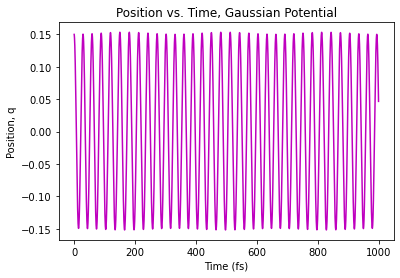

In [16]:
plt.plot(x_list, q_list, 'm')
plt.title("Position vs. Time, Gaussian Potential")
#plt.xlim(0, 100)
plt.xlabel("Time (fs)")
#plt.ylim(-5, 4)
plt.ylabel("Position, q")
plt.savefig('gaussian_qVt_10sig.png')
plt.show()

**3.2.1 Grpahing Potential versus Time**

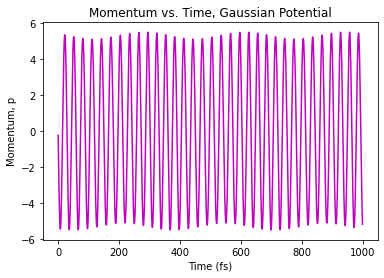

In [17]:
plt.plot(x_list, p_list, 'm')
plt.title("Momentum vs. Time, Gaussian Potential")
#plt.xlim(0, 100)
plt.xlabel("Time (fs)")
#plt.ylim(-0.5, 0.5)
plt.ylabel("Momentum, p")
plt.savefig('gaussian_pVt_10sig.png')
plt.show()

**3.3 Energy versus Time**

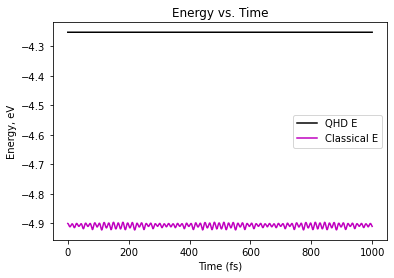

In [18]:
#plt.plot(x_list, e_list0)
plt.plot(x_list, e_list, "k")
plt.plot(x_list, e1_list, "m")
plt.legend(["QHD E", "Classical E"])
#plt.plot([0, 500], [0, 0], "k-")
plt.title("Energy vs. Time")
#plt.xlim(0, 1000)
plt.xlabel("Time (fs)")
#plt.ylim(-5.0, -4.9)
plt.ylabel("Energy, eV")
#plt.savefig('gaussian_eVt.png')
plt.show()

In [19]:
# Again, we must first define all variables as symbols. #

q, p, p2, x, x2, xp, dt, mass, D, alpha, sigma, q2 = symbols("q, p, p2, x, x2, xp, dt, mass, D, alpha, sigma q2")
q_0 = 0.0

########## EOM Calculations ##########

# If you want to see the output of any of the below, uncomment the desired print line. #

# There are two ways to derive the EOM's, using the `time_deriv` function and then the original way is with `QHD_int`
# The `time_deriv` function is used as it's more versatile at this time, however it's still not perfect.
# `QHD_int` uses the `time_deriv` function

px = xp
q1 = str(time_deriv(q, 1)*dt + q)
print("q = " + str(q1))

q21 = str(time_deriv(q, 2)*dt + q2)
print(q21)

p1 = str(time_deriv(p, 1)).replace("v(q)", str(potential_sym))
p1 = expand(sympify(p1).doit())
p1 = str(p1)
p1 = sympify(p1)
p1 = str(symmetrize(p1)*(0.5)*dt + p)
print("p = " + str(p1))

p21 = str(time_deriv(p, 2)).replace("v(q)", str(potential_sym))
p21 = expand(sympify(p21).doit())
p21 = str(-p21)
p21 = str(symmetrize(p21)*(0.5)*dt + p2)
p21 = str(p21)
print("p2 = " + str(p21))

q = dt*p/mass + q
2*dt*p*q/mass + q2
p = -1.0*alpha*dt*q*v_0*exp(-alpha*q**2) + p
p2 = -2.0*alpha*dt*p*q*v_0*exp(-alpha*q**2) + p2


In [20]:
### Specific Parameters: ###

v_0 = 5 # Hartree
sigma = 0.75 # Angstrom
mass = 1836 # a.u.


### Constants: ###

hbar = 0.6582  # eV * fs
convert = (1.0/17.586)
mass, q0, p0, s0, ps0, T, dt = 2980.0*convert, 0.15, 0.0, 0.05, 0.0, 500, 0.1
#alpha = 2.567
alpha = 1/(2*sigma**2)
alp = alpha


##### Initial Conditions #####

t = 0.0    
Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,pq,q2,p2,x,x2,xp,xq = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
q_0 = 0.0
q2 = q*q + s0*s0
pq = ps0*s0 + q*p
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2
x = exp(-alp*q0)*exp(0.5*alp*alp*s0*s0)
x2 = exp(-2.0*alp*q0)*exp(2.0*alp*alp*s0*s0)
xq = x*(q-alp*s0*s0)
xp = x*(p - s0*ps0*alp)

##### ----- #####

p2 = eval(p21)

q2 = eval(q21)

p = eval(p1)

q = eval(q1)

p = eval(p1)

q2 = eval(q21)

p2 = eval(p21)


Ekin_cl = 0.5*p*p/mass
Ekin    = 0.5*p2/mass
Epot_cl = -v_0*math.exp(-alpha*q**2)
Epot = -v_0*x
Etot_cl = Ekin_cl + Epot_cl
Etot    = Ekin    + Epot

##### Empty Lists for Data Storage: #####

q_list_classical = [] 
p_list_classical = []

In [21]:
### Time how long it takes to compute ###

import time 
begin = time.time()


### Compute the x values ###

dt = 0.1 # step size
t_i = 0.0 # start
t_f = 1000 # finish


### Compute the y values ###

i=0
while i<1:        
    s = (q**2 - q*q)
    if s>0.0:
        s = math.sqrt(s)
    else: 
        s = 0.0
    if s>0.0:
        ps = (pq - p*q)/s
    else: 
        ps = 0.0
    i = i+1


while t_i<=t_f:

    p2 = eval(p21)
    
    q2 = eval(q21)

    p = eval(p1)

    q = eval(q1)

    p = eval(p1)
    
    q2 = eval(q21)

    p2 = eval(p21)

    
    Ekin_cl = 0.5*p*p/mass
    Ekin    = 0.5*p2/mass
    Epot_cl = -v_0*math.exp(-alpha*q**2)
    Epot = -v_0*x
    Etot_cl = Ekin_cl + Epot_cl
    Etot    = Ekin    + Epot


    t_i = t_i + dt
    i=0
    while i<1:
        s = (q2 - q*q)
        if s>0.0:
            s = math.sqrt(s)
        else: 
            s = 0.0
        if s>0.0:
            ps = (pq - p*q)/s
        else: 
            ps = 0.0

        i = i+1
        q_list_classical.append(q)
        p_list_classical.append(p)
        e_list.append(Etot)
        e1_list.append(Etot_cl)
        
        print(q)


### Compute the end time ###
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

0.149845766025483
0.149653044934665
0.149383368623613
0.149036870259805
0.148613720988971
0.148114129882664
0.147538343873899
0.146886647680717
0.146159363717489
0.145356851993744
0.144479510000286
0.143527772582346
0.142502111799486
0.141403036771942
0.140231093513112
0.138986864747820
0.137670969716028
0.136284063961614
0.134826839105851
0.133300022605191
0.131704377492961
0.130040702104594
0.128309829785958
0.126512628584429
0.124650000922280
0.122722883252009
0.120732245693235
0.118679091650779
0.116564457413579
0.114389411734110
0.112155055387977
0.109862520713398
0.107512971130294
0.105107600638749
0.102647633296620
0.100134322676122
0.0975689512992311
0.0949528300518056
0.0922872975763421
0.0895737196433437
0.0868134885013106
0.0840080222054069
0.0811587639249101
0.0782671812295905
0.0753347653552205
0.0723630304484615
0.0693535127914268
0.0663077700062704
0.0632273802402011
0.0601139413313739
0.0569690699561615
0.0537944007583591
0.0505915854609254
0.0473622919609127
0.04410820

-0.0770707093580479
-0.0741220012744865
-0.0711346008959264
-0.0681100533441665
-0.0650499247495131
-0.0619558014279030
-0.0588292890391024
-0.0556720117265082
-0.0524856112391218
-0.0492717460363219
-0.0460320903761069
-0.0427683333875273
-0.0394821781280731
-0.0361753406268283
-0.0328495489142420
-0.0295065420394123
-0.0261480690758117
-0.0227758881164224
-0.0193917652592788
-0.0159974735844486
-0.0125947921235070
-0.00918550482258418
-0.00577139950008771
-0.00235426680021436
0.00106410085661564
0.00448191032526281
0.00789736878816392
0.0113086848072698
0.0147140693744773
0.0181117369594121
0.0214999065534280
0.0248768027086994
0.0282406565713008
0.0315897069071846
0.0349222011199921
0.0382363962596583
0.0415305600207991
0.0448029717299010
0.0480519233203702
0.0512757202945318
0.0544726826717124
0.0576411459215781
0.0607794618819466
0.0638859996603353
0.0669591465185555
0.0699973087397099
0.0729989124770021
0.0759624045838141
0.0788862534245609
0.0817689496658818
0.0846090070477774
0

-0.0395884377998723
-0.0428738977596175
-0.0461369043436471
-0.0493757549285976
-0.0525887608501568
-0.0557742483452030
-0.0589305594788751
-0.0620560530558079
-0.0651491055148156
-0.0682081118063520
-0.0712314862521259
-0.0742176633862992
-0.0771650987777459
-0.0800722698329017
-0.0829376765787839
-0.0857598424258128
-0.0885373149101182
-0.0912686664150632
-0.0939524948717674
-0.0965874244384629
-0.0991721061585608
-0.101705218597357
-0.104185468457344
-0.106611591172151
-0.108982351479161
-0.111296543970906
-0.113552993625369
-0.115750556315377
-0.117888119297265
-0.119964601679060
-0.121978954868446
-0.123930163000793
-0.125817243347559
-0.127639246705399
-0.129395257766334
-0.131084395469335
-0.132705813333699
-0.134258699774613
-0.135742278401286
-0.137155808298051
-0.138498584288841
-0.139769937185425
-0.140969234019810
-0.142095878261193
-0.143149310017842
-0.144129006224278
-0.145034480814122
-0.145865284878939
-0.146621006813414
-0.147301272447171
-0.147905745163513
-0.1484341

0.116633569862715
0.118746238808747
0.120797393647029
0.122785999142173
0.124711052956143
0.126571586048710
0.128366663058760
0.130095382666803
0.131756877939055
0.133350316653467
0.134874901608100
0.136329870912233
0.137714498260605
0.139028093191192
0.140270001326906
0.141439604601621
0.142536321470909
0.143559607107850
0.144508953584304
0.145383890037976
0.146183982825626
0.146908835662734
0.147558089749928
0.148131423886452
0.148628554570932
0.149049236089674
0.149393260592710
0.149660458157766
0.149850696842320
0.149963882723866
0.149999959928507
0.149958910647922
0.149840755144774
0.149645551746559
0.149373396827886
0.149024424781141
0.148598807975461
0.148096756703915
0.147518519118757
0.146864381154606
0.146134666439343
0.145329736192533
0.144449989111135
0.143495861242226
0.142467825842470
0.141366393224031
0.140192110586595
0.138945561835175
0.137627367383352
0.136238183941560
0.134778704290066
0.133249657036245
0.131651806355748
0.129985951717195
0.128252927589955
0.12645360

-0.146490052829026
-0.147183976350214
-0.147802164982609
-0.148344312958304
-0.148810152246442
-0.149199452636470
-0.149512021809218
-0.149747705395969
-0.149906387025671
-0.149987988360411
-0.149992469119235
-0.149919827090380
-0.149770098131945
-0.149543356161001
-0.149239713131123
-0.148859318998277
-0.148402361674971
-0.147869066972572
-0.147259698531634
-0.146574557740064
-0.145813983638944
-0.144978352815767
-0.144068079284867
-0.143083614354743
-0.142025446482012
-0.140894101111676
-0.139690140503355
-0.138414163543176
-0.137066805540927
-0.135648738012117
-0.134160668444577
-0.132603340049173
-0.130977531494284
-0.129284056623607
-0.127523764156914
-0.125697537373352
-0.123806293776906
-0.121850984743625
-0.119832595150246
-0.117752142983851
-0.115610678932205
-0.113409285954458
-0.111149078831879
-0.108831203698365
-0.106456837550439
-0.104027187736524
-0.101543491425279
-0.0990070150528433
-0.0964190537488452
-0.0937809307410864
-0.0910939967388499
-0.0883596292948169
-0.0855

0.144614441733087
0.143673717497407
0.142658997485509
0.141570785327163
0.140409621571046
0.139176083505149
0.137870784962672
0.136494376113036
0.135047543237661
0.133531008490106
0.131945529640174
0.130291899801612
0.128570947142980
0.126783534581301
0.124930559458106
0.123012953197466
0.121031680945646
0.118987741192001
0.116882165370759
0.114716017443354
0.112490393460983
0.110206421107090
0.107865259219498
0.105468097291948
0.103016154954813
0.100510681434817
0.0979529549935864
0.0953442823449396
0.0926859980508129
0.0899794638958064
0.0872260682403435
0.0844272253524984
0.0815843747185858
0.0786989803326562
0.0757725299650889
0.0728065344105215
0.0698025267154092
0.0667620613855536
0.0636867135739952
0.0605780782497124
0.0574377693476231
0.0542674189004340
0.0510686761529335
0.0478432066593738
0.0445926913646354
0.0413188256699140
0.0380233184837156
0.0347078912589892
0.0313742770172677
0.0280242193607267
0.0246594714731091
0.0212817951104961
0.0178929595829378
0.0144947407279851


-0.0715803900438778
-0.0685612575729177
-0.0655063103108849
-0.0624171316304177
-0.0592953243741045
-0.0561425099969795
-0.0529603276911054
-0.0497504334928571
-0.0465144993735739
-0.0432542123142906
-0.0399712733653086
-0.0366673966914090
-0.0333443086035556
-0.0300037465779737
-0.0266474582635309
-0.0232772004783821
-0.0198947381968712
-0.0165018435277167
-0.0131002946845327
-0.00969187494976110
-0.00627837163311396
-0.00286157502563933
0.000556722649459706
0.00397472828811382
0.00739064895763813
0.0108026929487957
0.0142090708265255
0.0176079964781902
0.0209976881582085
0.0243763695279461
0.0277422706897570
0.0310936292140833
0.0344286911585450
0.0377457120779754
0.0410429580243873
0.0443187065358861
0.0475712476135787
0.0507988846855654
0.0539999355571413
0.0571727333463734
0.0603156274042651
0.0634269842187625
0.0665051883019073
0.0695486430594844
0.0725557716425664
0.0755250177804040
0.0784548465941627
0.0813437453910583
0.0841902244384933
0.0869928177178493
0.0897500836576388
0.

-0.00195711549877185
-0.00537448374350609
-0.00878903280123374
-0.0121989717674412
-0.0156025124415913
-0.0189978703740273
-0.0223832659087974
-0.0257569252212828
-0.0291170813495260
-0.0324619752181770
-0.0357898566539985
-0.0390989853918971
-0.0423876320704789
-0.0456540792161574
-0.0488966222148790
-0.0521135702705686
-0.0553032473494387
-0.0584639931093444
-0.0615941638134167
-0.0646921332272453
-0.0677562934989362
-0.0707850560214129
-0.0737768522763821
-0.0767301346594351
-0.0796433772858058
-0.0825150767763581
-0.0853437530234271
-0.0881279499361882
-0.0908662361652806
-0.0935572058064593
-0.0961994790831015
-0.0987917030074393
-0.101332552020437
-0.103820728610283
-0.106254963909493
-0.108634018270690
-0.110956681821144
-0.113221774996191
-0.115428149051721
-0.117574686555899
-0.119660301860380
-0.121683941551254
-0.123644584880012
-0.125541244174845
-0.127372965232595
-0.129138827691710
-0.130837945386563
-0.132469466683508
-0.134032574799063
-0.135526488100603
-0.136950460389

0.0836791872991017
0.0864898163619167
0.0892553766767946
0.0919744472345967
0.0946456327534685
0.0972675643526429
0.0998389002049319
0.102358326167844
0.104824556393311
0.107236333916047
0.109592431220614
0.111891650787291
0.114132825616897
0.116314819734744
0.118436528673930
0.120496879938217
0.122494833444753
0.124429381946946
0.126299551437796
0.128104401534015
0.129843025841312
0.131514552301178
0.133118143519574
0.134652997077903
0.136118345826653
0.137513458162118
0.138837638286594
0.140090226452439
0.141270599190401
0.142378169522598
0.143412387160524
0.144372738688452
0.145258747732586
0.146069975116309
0.146806019001838
0.147466515018601
0.148051136378604
0.148559593979077
0.148991636492602
0.149347050444966
0.149625660280914
0.149827328417962
0.149951955288408
0.149999479369650
0.149969877202874
0.149863163400179
0.149679390640141
0.149418649651811
0.149081069187107
0.148666815981531
0.148176094703105
0.147609147889409
0.146966255872558
0.146247736691936
0.145453945994490
0.1

-0.141733173327553
-0.142810757684009
-0.143814774546385
-0.144744725654279
-0.145600149854485
-0.146380623250632
-0.147085759339365
-0.147715209133359
-0.148268661271445
-0.148745842116098
-0.149146515838514
-0.149470484491487
-0.149717588070245
-0.149887704561422
-0.149980749980262
-0.149996678396166
-0.149935481946642
-0.149797190839690
-0.149581873344630
-0.149289635771357
-0.148920622437953
-0.148475015626599
-0.147953035527647
-0.147354940171742
-0.146681025349802
-0.145931624520690
-0.145107108706329
-0.144207886374051
-0.143234403305882
-0.142187142454504
-0.141066623785567
-0.139873404106032
-0.138608076878207
-0.137271272019112
-0.135863655684808
-0.134385930039309
-0.132838833007687
-0.131223138012975
-0.129539653696482
-0.127789223621094
-0.125972725957204
-0.124091073150834
-0.122145211573598
-0.120136121154112
-0.118064814990482
-0.115932338943539
-0.113739771210467
-0.111488221878528
-0.109178832458582
-0.106812775398150
-0.104391253573774
-0.101915499762477
-0.099386776

0.142814264081821
0.141736926701218
0.140586555165750
0.139363721322298
0.138069033592694
0.136703136766966
0.135266711781398
0.133760475481017
0.132185180366105
0.130541614322356
0.128830600334270
0.127052996181385
0.125209694116955
0.123301620528686
0.121329735581139
0.119295032839430
0.117198538873878
0.115041312845239
0.112824446070223
0.110549061566973
0.108216313580234
0.105827387085964
0.103383497275150
0.100885889016656
0.0983358362989241
0.0957346416504228
0.0930836355387505
0.0903841757483538
0.0876376467368600
0.0848454589700651
0.0820090482356682
0.0791298749358871
0.0762094233591392
0.0732492009310212
0.0702507374448711
0.0672155842722469
0.0641453135537064
0.0610415173703251
0.0579058068964397
0.0547398115341551
0.0515451780302037
0.0483235695757946
0.0450766648901396
0.0418061572883888
0.0385137537347551
0.0352011738816500
0.0318701490956965
0.0285224214715224
0.0251597428342757
0.0217838737318397
0.0183965824177553
0.0149996438258877
0.0115948385379021
0.008183951744633

-0.0864992101841061
-0.0836887305470045
-0.0808346232903408
-0.0779383586910519
-0.0750014306079107
-0.0720253557241048
-0.0690116727695274
-0.0659619417231363
-0.0628777429957873
-0.0597606765939987
-0.0566123612651561
-0.0534344336247154
-0.0502285472660140
-0.0469963718533468
-0.0437395921990143
-0.0404599073250935
-0.0371590295107300
-0.0338386833257907
-0.0305006046517591
-0.0271465396907926
-0.0237782439638983
-0.0203974812992172
-0.0170060228114376
-0.0136056458733859
-0.0101981330808683
-0.00678527121185769
-0.00336885018113788
4.93380084669740e-5
0.00346750031714073
0.00688384372025577
0.0102965762605369
0.0137039080990599
0.0171040525639396
0.0204952271955703
0.0238756547872908
0.0272435644203635
0.0305971924921726
0.0339347837365691
0.0372545922353156
0.0405548824196097
0.0438339300606981
0.0470900232486267
0.0503214633582051
0.0535265660013092
0.0567036619646795
0.0598510981324212
0.0629672383924544
0.0660504645262103
0.0690991770809164
0.0721117962238638
0.0750867625780992

0.0156139663624623
0.0122104502630666
0.00880052985280216
0.00538599332132483
0.00196863156579955
-0.00144976285894132
-0.00486739679204895
-0.00828247751897070
-0.0116932138232754
-0.0150978170368437
-0.0184945020872804
-0.0218814885414160
-0.0252570016437763
-0.0286192733489142
-0.0319665433465193
-0.0352970600782419
-0.0386090817451948
-0.0419008773051255
-0.0451707274582830
-0.0484169256210394
-0.0516377788863617
-0.0548316089702710
-0.0579967531434677
-0.0611315651473447
-0.0642344160936561
-0.0673036953471573
-0.0703378113905800
-0.0733351926713536
-0.0762942884295380
-0.0792135695064812
-0.0820915291337660
-0.0849266837020628
-0.0877175735095566
-0.0904627634896643
-0.0931608439178121
-0.0958104310970894
-0.0984101680226453
-0.100958725024740
-0.103454800390407
-0.105897120963736
-0.108284442724808
-0.110615551347379
-0.112889262735429
-0.115104423538741
-0.117259911647693
-0.119354636667502
-0.121387540372153
-0.123357597138324
-0.125263814359571
-0.127105232841137
-0.128880927

0.0266361261089746
0.0299924644417876
0.0333330823897473
0.0366562322714035
0.0399601765745859
0.0432431889490608
0.0465035551874926
0.0497395741937858
0.0529495589379180
0.0561318373964192
0.0592847534776927
0.0624066679314180
0.0654959592413241
0.0685510245006662
0.0715702802697914
0.0745521634152246
0.0774951319297613
0.0803976657330990
0.0832582674525965
0.0860754631837956
0.0888478032303951
0.0915738628234152
0.0942522428193406
0.0968815703770791
0.0994604996136217
0.101987712238334
0.104461918165859
0.106881856107641
0.109246294142150
0.111554030263885
0.113803892911313
0.115994741473906
0.118125466778485
0.120194991555113
0.122202270882791
0.124146292615258
0.126026077787200
0.127840681001206
0.129589190795820
0.131270729995047
0.132884456039712
0.134429561301026
0.135905273376782
0.137310855370559
0.138645606154351
0.139908860614989
0.141099989884788
0.142218401556775
0.143263539884894
0.144234885969557
0.145131957928888
0.145954311056014
0.146701537962717
0.147373268709762
0.1

-0.141566995452138
-0.142655454317364
-0.143670422795399
-0.144611397131810
-0.145477910655979
-0.146269533932774
-0.146985874900704
-0.147626578996871
-0.148191329268992
-0.148679846474748
-0.149091889168691
-0.149427253776914
-0.149685774659673
-0.149867324162104
-0.149971812653172
-0.149999188552942
-0.149949438348245
-0.149822586596778
-0.149618695919656
-0.149337866982376
-0.148980238464171
-0.148545987015658
-0.148035327204682
-0.147448511450214
-0.146785829944153
-0.146047610560829
-0.145234218754007
-0.144346057441135
-0.143383566874596
-0.142347224499662
-0.141237544798851
-0.140055079122367
-0.138800415504281
-0.137474178464095
-0.136077028793331
-0.134609663326750
-0.133072814697831
-0.131467251078103
-0.129793775899949
-0.128053227562455
-0.126246479119944
-0.124374437952768
-0.122438045419986
-0.120438276493556
-0.118376139373649
-0.116252675084768
-0.114068957052302
-0.111826090659228
-0.109525212782644
-0.107167491309884
-0.104754124633970
-0.102286341128176
-0.099765398

0.149748369334687
0.149512944998532
0.149200634620501
0.148811592441370
0.148346010652542
0.147804119337024
0.147186186398387
0.146492517477554
0.145723455857209
0.144879382353606
0.143960715195529
0.142967909890126
0.141901459075336
0.140761892358581
0.139549776141407
0.138265713429724
0.136910343629277
0.135484342325983
0.133988421050755
0.132423327028407
0.130789842910269
0.129088786490090
0.127321010402842
0.125487401806032
0.123588882043124
0.121626406288683
0.119600963174880
0.117513574398985
0.115365294311508
0.113157209484658
0.110890438260818
0.108566130280741
0.106185465991231
0.103749656132056
0.101259941201922
0.0987175909033182
0.0961239035661259
0.0934802055498968
0.0907878506247442
0.0880482193308488
0.0852627183166098
0.0824327796555270
0.0795598601419402
0.0766454405658035
0.0736910249667215
0.0706981398675213
0.0676683334876894
0.0646031749370487
0.0615042533901059
0.0583731772415486
0.0552115732434236
0.0520210856245754
0.0488033751929792
0.0455601184216433
0.0422930

-0.131762361052812
-0.130101093689942
-0.128372599129017
-0.126577744187411
-0.124717430069336
-0.122792592021813
-0.120804198972234
-0.118753253147116
-0.116640789671706
-0.114467876150101
-0.112235612225553
-0.109945129120672
-0.107597589157242
-0.105194185255428
-0.102736140412123
-0.100224707158291
-0.0976611669951248
-0.0950468298089219
-0.0923830332646072
-0.0896711421778610
-0.0869125478658694
-0.0841086674767497
-0.0812609432977524
-0.0783708420423882
-0.0754398541166759
-0.0724694928647588
-0.0694612937941860
-0.0664168137812052
-0.0633376302564664
-0.0602253403715860
-0.0570815601470720
-0.0539079236021618
-0.0507060818671744
-0.0474777022790267
-0.0442244674606141
-0.0409480743847998
-0.0376502334238036
-0.0343326673848246
-0.0309971105327724
-0.0276453076010221
-0.0242790127911434
-0.0208999887625890
-0.0175100056133594
-0.0141108398526869
-0.0107042733668111
-0.00729209237893437
-0.00387608640447015
-0.000458047202707106
0.00296023227397330
0.00637695893218180
0.0097903405

0.0557849320726867
0.0525995401004157
0.0493866240888514
0.0461478577493368
0.0428849296975545
0.0395995425114369
0.0362934117748117
0.0329682651076357
0.0296258411837070
0.0262678887367855
0.0228961655560883
0.0195124374721562
0.0161184773341219
0.0127160639794324
0.00930698119710785
0.00589301668563273
0.00247596100659951
-0.000942393464767511
-0.00436025359106702
-0.00777582652500775
-0.0111873207613787
-0.0145929471875544
-0.0179909201313917
-0.0213794584053828
-0.0247567863459420
-0.0281211348467176
-0.0314707423848412
-0.0348038560390479
-0.0381187324986257
-0.0414136390621836
-0.0446868546252570
-0.0479366706558041
-0.0511613921566857
-0.0543593386142567
-0.0575288449322436
-0.0606682623501221
-0.0637759593452563
-0.0668503225181075
-0.0698897574598696
-0.0728926896019347
-0.0758575650466470
-0.0787828513788495
-0.0816670384577822
-0.0845086391889394
-0.0873061902755472
-0.0900582529493710
-0.0927634136806131
-0.0954202848667121
-0.0980275054999007
-0.100583741813429
-0.10308768

-0.00449342218114022
-0.00107561762377981
0.00234275116302365
0.00575989103346754
0.00917400956292392
0.0125833160994483
0.0159860228133540
0.0193803457437122
0.0227645058406460
0.0261367300023030
0.0294952521054035
0.0328383140282878
0.0361641666654032
0.0394710709322035
0.0427572987594602
0.0460211340760202
0.0492608737790768
0.0524748286910631
0.0556613245023132
0.0588187026986821
0.0619453214733575
0.0650395566221443
0.0680998024215492
0.0711244724890413
0.0741120006249152
0.0770608416352328
0.0799694721353717
0.0828363913337568
0.0856601217954081
0.0884392101849810
0.0911722279890351
0.0938577722173075
0.0964944660828254
0.0990809596607321
0.101615930525753
0.104098084368272
0.106526155589026
0.108898907872488
0.111215134739007
0.113473660075867
0.115673338647413
0.117813056584453
0.119891731853170
0.121908314703797
0.123861788099351
0.125751168124730
0.127575504376506
0.129333880333756
0.131025413710302
0.132649256788737
0.134204596736603
0.135690655905151
0.137106692111030
0.138

-0.107504960316516
-0.109854699985485
-0.112147428717541
-0.114381982988884
-0.116557230355760
-0.118672069935441
-0.120725432866815
-0.122716282750855
-0.124643616071267
-0.126506462595642
-0.128303885757431
-0.130034983019125
-0.131698886216979
-0.133294761887682
-0.134821811577352
-0.136279272133255
-0.137666415978635
-0.138982551371074
-0.140227022644756
-0.141399210437047
-0.142498531899762
-0.143524440895509
-0.144476428179464
-0.145354021566943
-0.146156786087093
-0.146884324123040
-0.147536275538779
-0.148112317793104
-0.148612166040814
-0.149035573221460
-0.149382330135818
-0.149652265510286
-0.149845246049362
-0.149961176476331
-0.149999999562266
-0.149961696143411
-0.149846285127000
-0.149653823485519
-0.149384406239396
-0.149038166428079
-0.148615275069431
-0.148115941107331
-0.147540411347357
-0.146888970380393
-0.146161940493970
-0.145359681571141
-0.144482590976639
-0.143531103430074
-0.142505690865878
-0.141406862279704
-0.140235163560949
-0.138991177311077
-0.137675522

0.149552750014064
0.149251842592821
0.148874178077685
0.148419943030695
0.147889361915005
0.147282697025643
0.146600248408117
0.145842353764674
0.145009388347998
0.144101764842087
0.143119933230060
0.142064380648587
0.140935631228645
0.139734245922266
0.138460822314933
0.137115994423268
0.135700432477643
0.134214842689322
0.132659967001766
0.131036582825681
0.129345502757429
0.127587574280399
0.125763679448936
0.123874734554443
0.121921689773264
0.119905528795978
0.117827268437734
0.115687958229289
0.113488679988406
0.111230547371311
0.108914705403922
0.106542329992587
0.104114627414090
0.101632833784750
0.0990982145084021
0.0965120637031767
0.0938757036069385
0.0911904839613577
0.0884577813745875
0.0856789986625813
0.0828555641691244
0.0799889310647014
0.0770805766243694
0.0741320014848557
0.0711447288811481
0.0681203038628976
0.0650602924910022
0.0619662810147947
0.0588398750303049
0.0556826986201211
0.0524963934754238
0.0492826180008150
0.0460430464026152
0.0427793677613474
0.039493

-0.128633365529080
-0.126848303979647
-0.124997647332860
-0.123082325805404
-0.121103303349307
-0.119061577273509
-0.116958177846337
-0.114794167878530
-0.112570642286506
-0.110288727635568
-0.107949581662766
-0.105554392779169
-0.103104379551326
-0.100600790161736
-0.0980449018481575
-0.0954380203216483
-0.0927814791632622
-0.0900766391993514
-0.0873248878554884
-0.0845276384890506
-0.0816863297005650
-0.0788024246239510
-0.0758774101958537
-0.0729127964043048
-0.0699101155170011
-0.0668709212895405
-0.0637967881540059
-0.0606893103883396
-0.0575501012670015
-0.0543807921934546
-0.0511830318150722
-0.0479584851211110
-0.0447088325244397
-0.0414357689277644
-0.0381410027751323
-0.0348262550895438
-0.0314932584975401
-0.0281437562416764
-0.0247795011818261
-0.0214022547862959
-0.0180137861137647
-0.0146158707870854
-0.0112102899600163
-0.00779882927797208
-0.00438327783389872
-0.000965427120398764
0.00245293002076035
0.00587000045061047
0.00928399178527155
0.0126931134474159
0.016095577

0.0530741105993346
0.0498651744327949
0.0466301385537315
0.0433706894248371
0.0400885276118050
0.0367853668290393
0.0334629329718237
0.0301229631358340
0.0267672046249200
0.0233974139481142
0.0200153558068646
0.0166228020735116
0.0132215307620641
0.00981332499234760
0.00639997194862247
0.00298326183378676
-0.000435013179708810
-0.00385306000109427
-0.00726908567351653
-0.0106812984261293
-0.0140879087248882
-0.0174871303209067
-0.0208771812952359
-0.0242562850989443
-0.0276226715873858
-0.0309745780475651
-0.0343102502175305
-0.0376279432967500
-0.0409259229464528
-0.0442024662789519
-0.0474558628349969
-0.0506844155482410
-0.0538864416959477
-0.0570602738351027
-0.0602042607231397
-0.0633167682225348
-0.0663961801885705
-0.0694408993396173
-0.0724493481093324
-0.0754199694802234
-0.0783512277980744
-0.0812416095667870
-0.0840896242232348
-0.0868938048917855
-0.0896527091181918
-0.0923649195826070
-0.0950290447915250
-0.0976437197484982
-0.100207606603532
-0.102719395281097
-0.10517780

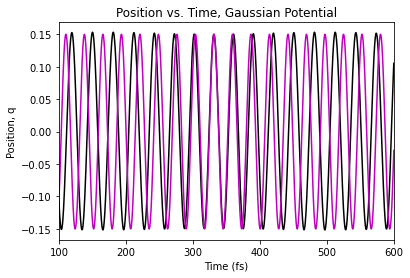

In [30]:
plt.plot(x_list, q_list, 'k')
plt.plot(x_list, q_list_classical, "m")
plt.title("Position vs. Time, Gaussian Potential")
plt.xlim(100, 600)
plt.xlabel("Time (fs)")
#plt.ylim(-5, 4)
plt.ylabel("Position, q")
#plt.savefig('gaussian_qVt_10sig.png')
plt.show()